## Explainable Brain embedding

#### This notebook calculates 
- correlations between HBN / ABCD raw features and the first brain embedding. (used for brain map visualization with ggseg in R)
- spin permutation testing betweeen correlation maps to test their similarity

- Author: Dominik Kraft

In [7]:
import numpy as np
import pandas as pd

from utils import load_mri, load_abcd_mri

In [8]:
## define small helper function 
def dict_to_df(list_of_dicts):
    
    '''''
    Small helper function that turns dict into dataframe with grouping variable (area, vol)
    for plotting with ggseg.
    Input: list of dictionaries, currently expects [area, vol] ordering
    Output: concated dataframe 
    '''''
    
    list_of_dfs = []
    for ix, d in enumerate(list_of_dicts):
        df = pd.DataFrame.from_dict(d, orient='index', columns=['r'])
        df.index.name = 'label'
        df.reset_index(inplace=True)
        if ix == 0:
            df['group'] = "area"
            df["label"] = df["label"].apply(lambda row: row.replace("_area", ""))
        elif ix == 1:
            df["group"] = "volume"
            df["label"] = df["label"].apply(lambda row: row.replace("_volume", ""))

        list_of_dfs.append(df)
        
    return pd.concat(list_of_dfs)

### HBN

In [9]:
### load embeddings ### 
file = "outputs/outputdict_hbn.npy"

dic = np.load(file ,allow_pickle='TRUE').item()

hbn = dic["demos"][1] 
hbn["prediction"] = np.squeeze(dic["predictions"]) # predicted embedding
hbn.rename(columns={"Identifiers":"subjectkey"},inplace=True)

### exclude first subject since it was err. not excluded ### 
hbn = hbn.loc[~hbn["DX_01"].isin(
            ["No Diagnosis Given", "No Diagnosis Given: Incomplete Eval"]
        )]
hbn.shape

(2271, 16)

In [10]:
### load raw data 

exclude_ROIs = [
    "CSF",
    "Left-VentralDC",
    "Left-vessel",
    "Left-choroid-plexus",
    "Right-VentralDC",
    "Right-vessel",
    "Right-choroid-plexus",
    "5th-Ventricle",
    "WM-hypointensities",
    "Left-WM-hypointensities",
    "Right-WM-hypointensities",
    "non-WM-hypointensities",
    "Left-non-WM-hypointensities",
    "Right-non-WM-hypointensities",
    "Optic-Chiasm",
    "BrainSegVol",
    "BrainSegVolNotVent",
    "lhCortexVol",
    "rhCortexVol",
    "CortexVol",
    "lhCerebralWhiteMatterVol",
    "rhCerebralWhiteMatterVol",
    "CerebralWhiteMatterVol",
    "SubCortGrayVol",
    "TotalGrayVol",
    "SupraTentorialVol",
    "SupraTentorialVolNotVent",
    "MaskVol",
    "BrainSegVol-to-eTIV",
    "MaskVol-to-eTIV",
    "lhSurfaceHoles",
    "rhSurfaceHoles",
    "SurfaceHoles",
    "BrainSegVolNotVent",
    "eTIV",
    "rh_MeanThickness_thickness",
    "lh_MeanThickness_thickness",
    "EstimatedTotalIntraCranialVol",
    "lh_WhiteSurfArea_area",
    "rh_WhiteSurfArea_area",
]
hbn_area, hbn_volume = load_mri(dataset="HBN", exclude=exclude_ROIs)


In [11]:
emb_area_hbn = hbn[["subjectkey", "prediction"]].merge(hbn_area, on="subjectkey")
emb_vol_hbn = hbn[["subjectkey", "prediction"]].merge(hbn_volume, on="subjectkey")
## merge dataframes

In [12]:
## calculate correlations between embedding and all raw features and store as dict 
area_corr_hbn = dict(emb_area_hbn.corrwith(emb_area_hbn["prediction"])*(-1)) ## sign is not informative 
del area_corr_hbn["prediction"]

vol_corr_hbn = dict(emb_vol_hbn.corrwith(emb_vol_hbn["prediction"])*(-1))
del vol_corr_hbn["prediction"]

In [13]:
hbn_feature_embedding_corr = dict_to_df([area_corr_hbn, vol_corr_hbn])
hbn_feature_embedding_corr.shape

#hbn_feature_embedding_corr.to_csv("hbn_feature_embedding_corr.csv", index=False)

(136, 3)

### ABCD

In [14]:
abcd_dic = np.load('outputs/outputdict_base_followup.npy',allow_pickle='TRUE').item()

abcd = abcd_dic["demos"][0]
abcd["prediction"] = np.squeeze(abcd_dic["predictions"][0]) # predicted embedding
abcd["prediction2y"] = np.squeeze(abcd_dic["predictions"][1])


In [ ]:
tmp = load_abcd_mri()

abcd_area_base = tmp[1][1]
abcd_vol_base = tmp[1][2]

abcd_area_foll = tmp[2][1]
abcd_vol_foll = tmp[2][2]



In [16]:
## abcd columns are labeled differently, however, are in the same order as the resulting hbn labels
## thus we can just create two dictionaries for mapping 
rename_abcd_area = dict(zip(abcd_area_base.columns[1:], hbn_feature_embedding_corr.label[:68]))
rename_abcd_vol = dict(zip(abcd_vol_base.columns[1:], hbn_feature_embedding_corr.label[:68]))

rename_abcd_area.update(rename_abcd_vol) ### now has both dicts

In [47]:
baseline = []
follow = []
abcd_for_spin_permutation = []

for ix, df in enumerate([abcd_area_base, abcd_vol_base, abcd_area_foll, abcd_vol_foll]): #iterate over all dataframes 
    
    if ix < 2: # baseline
        merged = abcd[["subjectkey", "prediction"]].merge(df, on="subjectkey") # merge with predicted embedding 
        dictionary = dict(merged.corrwith(merged["prediction"])) # correlate embedding with raw features
        del dictionary["prediction"] # delete self correlation 
        baseline.append(dictionary) # create list of dicts
        abcd_for_spin_permutation.append(merged.corrwith(merged["prediction"])[1:])

        
    elif ix >= 2:
        merged = abcd[["subjectkey", "prediction2y"]].merge(df, on="subjectkey")
        dictionary = dict(merged.corrwith(merged["prediction2y"]))
        del dictionary["prediction2y"]
        follow.append(dictionary)
        abcd_for_spin_permutation.append(merged.corrwith(merged["prediction2y"])[1:])



abcd_feature_embedding_corr_baseline = dict_to_df(baseline) # turn list of dicts into concat. dataframe 
abcd_feature_embedding_corr_baseline["label"] = list(rename_abcd_area.values()) ## change label names to match ggseg for plotting (e.g. same as hbn)

abcd_feature_embedding_corr_follow = dict_to_df(follow)
abcd_feature_embedding_corr_follow["label"] = list(rename_abcd_area.values())



#abcd_feature_embedding_corr_baseline.to_csv("abcd_feature_embedding_corr_baseline.csv", index=False)
#abcd_feature_embedding_corr_follow.to_csv("abcd_feature_embedding_corr_follow.csv", index=False)

### spin permutation to test correlation between feature-embedding maps across HBN-ABCD

In [102]:
## note: for running this, one needs to install https://enigma-toolbox.readthedocs.io/en/latest/pages/01.install/index.html 

## spin permutation 
from enigmatoolbox.permutation_testing import spin_test, shuf_test

permuted_pvals = []
permuted_corrs = []
true_corrs = []
# order: baseline_area, baseline_volume, follow_area, follow_volume
hbn_spin_permutation = [pd.Series(area_corr_hbn), pd.Series(vol_corr_hbn)]*2 #area, vol, area, vol 

for ix, series in enumerate(abcd_for_spin_permutation):
    series.index = hbn_spin_permutation[ix].index # match index 
    
    p_perm, corr_perm = spin_test(series, hbn_spin_permutation[ix], surface_name='fsa5', 
                                  parcellation_name='aparc',type='pearson', n_rot=5000, null_dist=True)
    permuted_pvals.append(p_perm)
    permuted_corrs.append(corr_perm)
    
    true_corrs.append(series.corr(hbn_spin_permutation[ix]))
    

permutation 100 of 5000
permutation 200 of 5000
permutation 300 of 5000
permutation 400 of 5000
permutation 500 of 5000
permutation 600 of 5000
permutation 700 of 5000
permutation 800 of 5000
permutation 900 of 5000
permutation 1000 of 5000
permutation 1100 of 5000
permutation 1200 of 5000
permutation 1300 of 5000
permutation 1400 of 5000
permutation 1500 of 5000
permutation 1600 of 5000
permutation 1700 of 5000
permutation 1800 of 5000
permutation 1900 of 5000
permutation 2000 of 5000
permutation 2100 of 5000
permutation 2200 of 5000
permutation 2300 of 5000
permutation 2400 of 5000
permutation 2500 of 5000
permutation 2600 of 5000
permutation 2700 of 5000
permutation 2800 of 5000
permutation 2900 of 5000
permutation 3000 of 5000
permutation 3100 of 5000
permutation 3200 of 5000
permutation 3300 of 5000
permutation 3400 of 5000
permutation 3500 of 5000
permutation 3600 of 5000
permutation 3700 of 5000
permutation 3800 of 5000
permutation 3900 of 5000
permutation 4000 of 5000
permutati

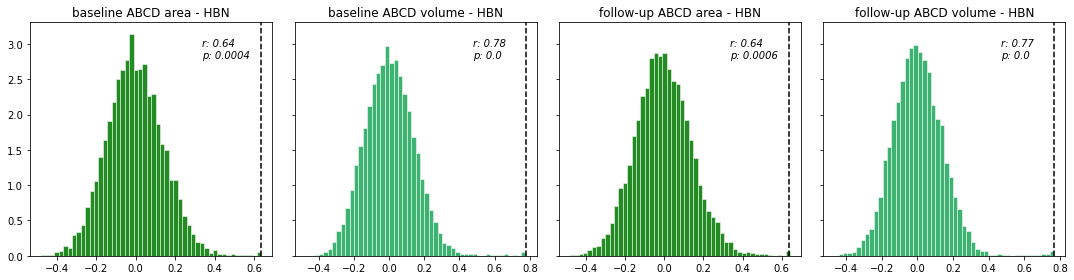

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns



n_perm=5000
titles = ["baseline ABCD area - HBN", "baseline ABCD volume - HBN", "follow-up ABCD area - HBN", "follow-up ABCD volume - HBN"]
colors = ["forestgreen", "mediumseagreen"]*2
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

for r in range(4):
    ax[r].hist(permuted_corrs[r], bins=50, density=True, edgecolor='white', lw=0.5, color=colors[r])
    ax[r].axvline(true_corrs[r], color="black", linestyle="--")
    ax[r].text(true_corrs[r]-0.3,2.8, 
               "r: {}\np: {}".format(true_corrs[r].round(2),(permuted_corrs[r]>true_corrs[r]).sum()/n_perm),
               fontstyle="italic", fontsize=10)
    ax[r].set_title(titles[r], fontsize=12)

plt.tight_layout()
